In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import utils as ut

system_name = 'kite2d_vrel'
run_name = 'sarsa_nic1'
data_dir = '../data/' + system_name + '/' + run_name + '/'
plot_dir = '../plots/' + system_name + '/' + run_name + '/'

# Learning of the 2d kite with a non-constant wind
- The aggregate state is the discretized attack angle and the angle with the relative valocity.
- The wind velocity is based on a simple stream-function
- The initial angle with the ground, $\theta$, is constant
- The initial attack angle can be choosen constant or random
- The algortihm is sarsa

In [47]:
# ENVIRONMENT PARAMETERS
env_params = dict()
env_params['int_steps'] = 0.0005 # sec
env_params['ep_length'] = 200 # sec
env_params['decision_time'] = 0.05 # sec
env_params['init_theta'] = np.pi/4 # rad
env_params['init_dtheta'] = 0 # rad
# attack angles
env_params['alphas'] = [-4, 0, 4, 8, 12, 14, 16, 18, 20]
env_params['CL_alphas'] = [0.05, 0.35, 0.55, 0.75, 0.9, 1.0, 1.08, 1.1, 1.05]
env_params['CD_alphas'] = [0.001, 0.01, 0.03, 0.07, 0.1, 0.13, 0.18, 0.18, 0.21]
env_params['init_alpha'] = len(env_params['alphas'])+1 # index, if larger than len it's random
#env_params['beta_bins'] = np.linspace(-np.pi, np.pi, 25)
env_params['beta_bins'] = [-np.pi, -3.08, -3.0, -2.9, -2.7, -2.4, -2.1, -1.8, -1.5,-1.2, -0.9, -0.6, -0.3, 0., \
                           0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 2.9, 3.0, 3.08, np.pi]
print('Beta bins: ', np.rad2deg(env_params['beta_bins']))
# wind
env_params['wind_type'] = 'stream'
env_params['k_wind'] = 0.5 # 1/sec
env_params['eps_wind'] = 0.2

# ALG PARAMETERS
alg_params = dict()
alg_params['alg_type'] = 'sarsa' # 'ac' for actor-critic, 'nac' for natural actor-critic
alg_params['gamma'] = 1.0
alg_params['n_steps'] = 40000000 # Number of training steps
print('Dynamical steps: ', alg_params['n_steps']*env_params['decision_time']/env_params['int_steps'])
print('Dynamical time, in seconds: ', alg_params['n_steps']*env_params['decision_time'])

alg_params['traj_points'] = 1000
alg_params['init_q_path'] = '../data/' + system_name + '/sarsa_nic0/best_quality.txt' # Policy prior, comment for flat policy
alg_params['init_quals'] = env_params['k_wind']*5*env_params['ep_length']
# Learning rate
alg_params['lr0'] = 0.02
alg_params['lrc'] = 100
alg_params['lr_expn'] = 1
alg_params['lr_burn'] = 5000
# Exploration parameter
alg_params['eps0'] = 0.001
alg_params['epsc'] = 100
alg_params['eps_expn'] = 1
alg_params['eps_burn'] = 3000

Beta bins:  [-180.         -176.4710009  -171.88733854 -166.15776059 -154.69860469
 -137.50987083 -120.32113698 -103.13240312  -85.94366927  -68.75493542
  -51.56620156  -34.37746771  -17.18873385    0.           17.18873385
   34.37746771   51.56620156   68.75493542   85.94366927  103.13240312
  120.32113698  137.50987083  154.69860469  166.15776059  171.88733854
  176.4710009   180.        ]
Dynamical steps:  4000000000.0
Dynamical time, in seconds:  2000000.0


In [48]:
# WRITING THE PARAMETERS
ut.write_params(env_params, data_dir, "param_env.txt")
ut.write_params(alg_params, data_dir, "param_alg.txt")

In [49]:
# COMPILING C++ SCRIPT
comp_list = np.array(["g++", "-o", "run.exe", "run.cpp", "../lib/alg.cpp", "../lib/nac.cpp", "../lib/qalg.cpp", "../lib/eval.cpp", "../lib/utils.cpp", "../lib/wind.cpp", 
            "../lib/envs/kite.cpp", "../lib/envs/kite2d.cpp", "../lib/envs/kite3d.cpp", "-std=c++17"])
comp_str = ""
for s in comp_list: comp_str+=s+" "
print('To compile from terminal: ')
print(comp_str)

To compile from terminal: 
g++ -o run.exe run.cpp ../lib/alg.cpp ../lib/nac.cpp ../lib/qalg.cpp ../lib/eval.cpp ../lib/utils.cpp ../lib/wind.cpp ../lib/envs/kite.cpp ../lib/envs/kite2d.cpp ../lib/envs/kite3d.cpp -std=c++17 


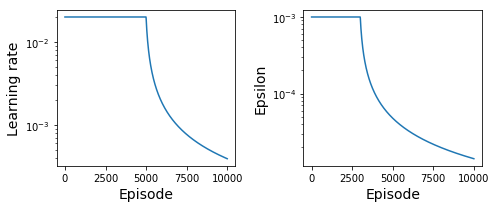

In [53]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(7,3))

ax1.set_xlabel('Episode', fontsize=14)
ax1.set_ylabel('Learning rate', fontsize=14)
ax1.set_yscale('log')
xs = np.linspace(0, alg_params['n_steps']/env_params['ep_length']*env_params['decision_time'], alg_params['traj_points'])
lr = [ut.p_law_burn(x, alg_params['lr_burn'], alg_params['lr_expn'], alg_params['lr0'], alg_params['lrc']) for x in xs]
ax1.plot(xs, lr)

ax2.set_xlabel('Episode', fontsize=14)
ax2.set_ylabel('Epsilon', fontsize=14)
ax2.set_yscale('log')
eps = [ut.p_law_burn(x, alg_params['eps_burn'], alg_params['eps_expn'], alg_params['eps0'], alg_params['epsc']) for x in xs]
ax2.plot(xs, eps)

plt.tight_layout()
plt.savefig(plot_dir+'lr.png', dpi=200)

In [54]:
import numpy as np
#v_traj = np.loadtxt(data_dir + system_name + '/' + run_name + '/value_traj.txt', dtype='float')
q_traj, s_labels, a_labels = ut.read_2d_traj(data_dir+'/quality_traj.txt')
r_traj, head = ut.read_traj(data_dir+'/return_traj.txt')

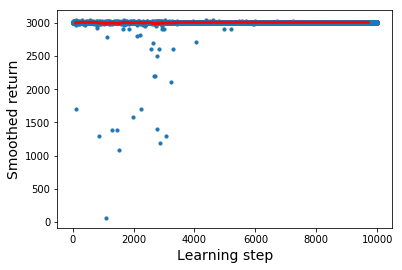

In [55]:
plt.xlabel('Learning step', fontsize=14)
plt.ylabel('Smoothed return', fontsize=14)
x, y = ut.smooth_traj(r_traj[:,0], 1)
plt.scatter(x,y,s=10)
x, y = ut.smooth_traj(r_traj[:,0], 200)
plt.plot(x,y, color='red', lw=3)

plt.savefig(plot_dir+'return.png', dpi=200)

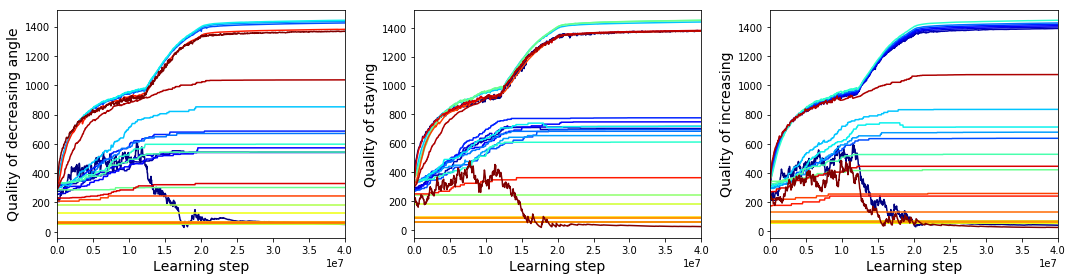

In [61]:
n_alphas=len(env_params['alphas'])
n_betas=len(env_params['beta_bins'])-1
alpha = n_alphas-1
betas = np.arange(n_betas)
colors = plt.cm.jet(np.linspace(0,1,len(betas)))

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))
states = range(0,len(q_traj[0]))

ax1.set_xlabel('Learning step', fontsize=14)
ax1.set_ylabel('Quality of decreasing angle', fontsize=14)
xs = np.linspace(0, alg_params['n_steps'] , alg_params['traj_points'] )
ax1.set_xlim([0,alg_params['n_steps']])
#ax1.set_ylim([-100,alg_params['init_values']])
count=0
for b in betas:
    index = b+alpha*n_betas
    ax1.plot(xs, q_traj[:,index,0], label=str(index) + " " + s_labels[index], c=colors[count])
    count+=1
#ax1.legend()

ax2.set_xlabel('Learning step', fontsize=14)
ax2.set_ylabel('Quality of staying', fontsize=14)
ax2.set_xlim([0,alg_params['n_steps']])
#ax1.set_ylim([-100,alg_params['init_values']])
count=0
for b in betas:
    index = b+alpha*n_betas
    ax2.plot(xs, q_traj[:,index,1], label=s_labels[index], c=colors[count])
    count+=1

ax3.set_xlabel('Learning step', fontsize=14)
ax3.set_ylabel('Quality of increasing', fontsize=14)
ax3.set_xlim([0,alg_params['n_steps']])
#ax1.set_ylim([-100,alg_params['init_values']])
count=0
for b in betas:
    index = b+alpha*n_betas
    ax3.plot(xs, q_traj[:,index,2], label=s_labels[index], c=colors[count])
    count+=1
    
plt.tight_layout()
#plt.savefig(plot_dir+'qualities_a='+str(env_params['alphas'][alpha])+'.png', dpi=200)

In [63]:
n_betas

26